In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
import random

# importing sklearn libraries
from sklearn import neural_network, linear_model, preprocessing, svm, tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score,mean_squared_error, r2_score,make_scorer
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv('forestfires.csv')

In [3]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


<br>X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
<br>Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
<br>month - month of the year: "jan" to "dec"
<br>day - day of the week: "mon" to "sun"
<br>FFMC - FFMC index from the FWI system: 18.7 to 96.20
<br>DMC - DMC index from the FWI system: 1.1 to 291.3
<br>DC - DC index from the FWI system: 7.9 to 860.6
<br>ISI - ISI index from the FWI system: 0.0 to 56.10
<br>temp - temperature in Celsius degrees: 2.2 to 33.30
<br>RH - relative humidity in %: 15.0 to 100
<br>wind - wind speed in km/h: 0.40 to 9.40
<br>rain - outside rain in mm/m2 : 0.0 to 6.4
<br>area - the burned area of the forest (in ha): 0.00 to 1090.84

https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-system#:~:text=The%20Fine%20Fuel%20Moisture%20Code,It%20ranges%20from%200%2D101.

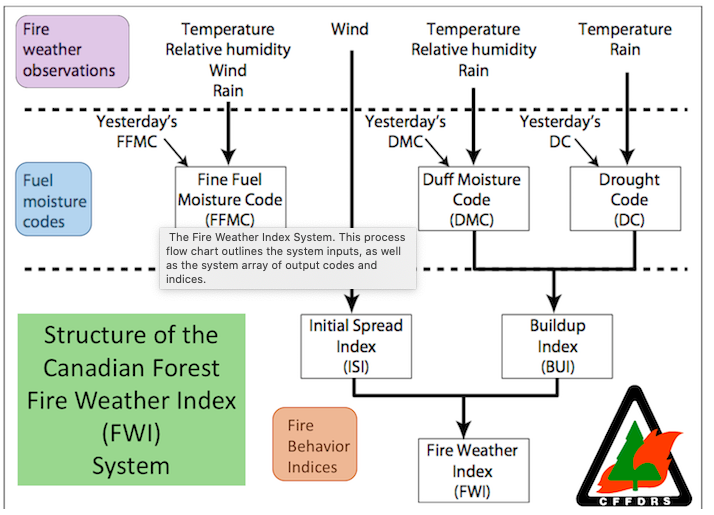

**FWI Fuel Moisture Codes**

There are 3 fuel moisture categories, or codes, in the FWI system, compared to 7 found in National Fire Danger Rating System (NFDRS). These are generally represented as unitless codes instead of fuel moisture content (represented as a % of dry weight). They can be converted to moisture content, and in fact, are converted each day as part of the daily or hourly calculations.
<br>
<br>
<br>
The Fine Fuel Moisture Code (FFMC) represents fuel moisture of forest litter fuels under the shade of a forest canopy. It is intended to represent moisture conditions for shaded litter fuels, the equivalent of 16-hour timelag. It ranges from 0-101. Subtracting the FFMC value from 100 can provide an estimate for the equivalent (approximately 10h) fuel moisture content, most accurate when FFMC values are roughly above 80.

(Fine Fuel Moisture Code)(FFMC) :Orman altı yüzeyini kaplayan ölü organik örtüden (dal,
yaprak, kabuk vb. organik döküntü ve artıklar) oluşan ince
katmanın nem içeriği kodu.Orman tabanında 0-1,2 cm derinlikte bir alanda
bulunan (0,25 kg/m2) kuru otlar ve diğer yanıcı materyallerin nem oranını göstermektedir
<br>
<br>
<br>
The Duff Moisture Code (DMC) represents fuel moisture of decomposed organic material underneath the litter. System designers suggest that it is represents moisture conditions for the equivalent of 15-day (or 360 hr) timelag fuels. It is unitless and open ended. It may provide insight to live fuel moisture stress.

Organik yüzey artık ve döküntülerinin altında, daha derinde bulunan ayrışmış organik maddenin nem içeriği kodu
(Duff Moisture Code) (DMC): Orman tabanında 1,2 – 7 cm
derinlikte bulunan (5 kg/m2) çürüyen (decomposing) organik materyallerin nem içeriğini göstermektedir
<br>
<br>
<br>
The Drought Code (DC), much like the Keetch-Byrum Drought Index, represents drying deep into the soil. It approximates moisture conditions for the equivalent of 53-day (1272 hour) timelag fuels. It is unitless, with a maximum value of 1000. Extreme drought conditions have produced DC values near 800.

Kuraklık kodu (Drought Code) (DC): Orman tabanında
7+ cm derinlikte bulunan (25kg/m2) organik nem içeriğini
göstermektedir
<br>
<br>
<br>
Initial Spread Index The Initial Spread Index (ISI) is a numeric rating of the expected rate of fire spread. It combines the effects of wind and the FFMC on rate of spread without the influence of variable quantities of fuel.

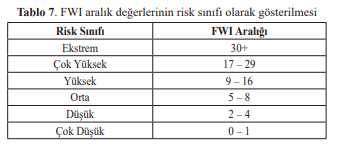

In [4]:
# The dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


In [6]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [7]:
from datetime import datetime
df["month"] = df["month"].apply(lambda x: datetime.strptime(x,"%b").month)

In [8]:
df.day.unique()

array(['fri', 'tue', 'sat', 'sun', 'mon', 'wed', 'thu'], dtype=object)

In [9]:
df.replace(('mon','tue','wed','thu','fri','sat','sun'),(1,2,3,4,5,6,7), inplace=True)

In [10]:
# If fire area > 0, set the value to 1 and change column name from area to label so that we can see it as a classification problem
df['label'] = np.where(df['area']>0, 1,0)

In [11]:
df.sample(25)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,label
171,8,6,8,3,85.6,90.4,609.6,6.6,17.4,50,4.0,0.0,2.69,1
494,6,6,8,6,96.0,164.0,643.0,14.0,30.8,30,4.9,0.0,8.59,1
399,9,5,6,3,93.3,49.5,297.7,14.0,28.0,34,4.5,0.0,0.00,0
281,6,5,12,2,85.4,25.4,349.7,2.6,5.1,24,8.5,0.0,24.77,1
505,1,2,8,4,91.0,163.2,744.4,10.1,26.7,35,1.8,0.0,5.80,1
126,3,5,3,1,87.6,52.2,103.8,5.0,9.0,49,2.2,0.0,0.00,0
284,5,4,2,5,85.2,4.9,15.8,6.3,7.5,46,8.0,0.0,24.24,1
82,1,2,8,2,94.8,108.3,647.1,17.0,18.6,51,4.5,0.0,0.00,0
157,2,2,8,3,92.1,111.2,654.1,9.6,18.4,45,3.6,0.0,1.63,1
130,4,6,2,6,68.2,21.5,87.2,0.8,15.4,40,2.7,0.0,0.00,0


In [12]:
df.drop("area",axis=1,inplace=True)

<AxesSubplot:>

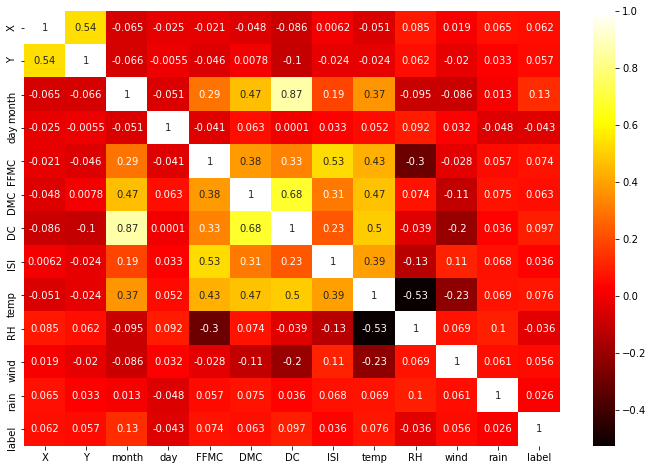

In [13]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),cmap="hot",annot=True)

In [14]:
# To find high correlation
df.corr()["label"].sort_values(ascending=False)

label    1.000000
month    0.130329
DC       0.096724
temp     0.076047
FFMC     0.073823
DMC      0.062672
X        0.062491
Y        0.056892
wind     0.055702
ISI      0.035663
rain     0.025550
RH      -0.035587
day     -0.042970
Name: label, dtype: float64

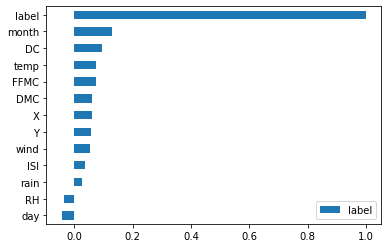

In [15]:
df.corr()[['label']].sort_values(by="label").plot.barh();

/Users/Macbook/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

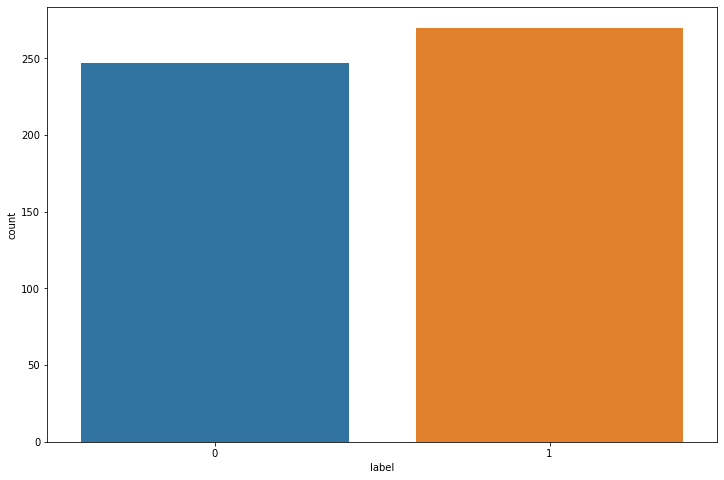

In [16]:
plt.figure(figsize=(12,8))
sns.countplot(df["label"])

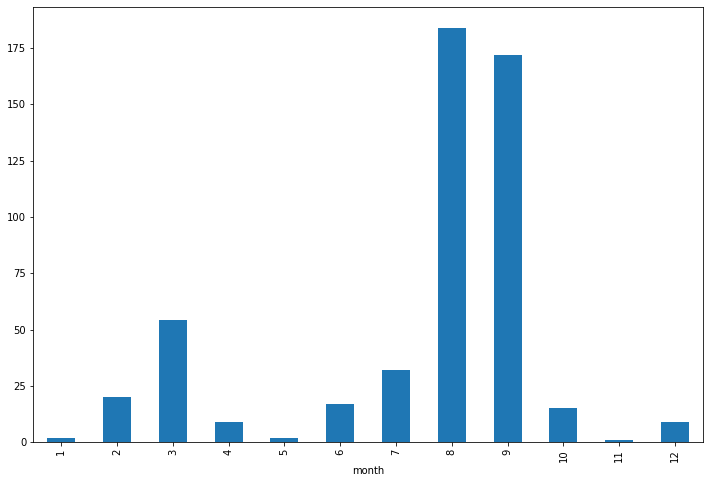

In [17]:
plt.figure(figsize=(12,8))
df.groupby("month").count()["label"].plot.bar();

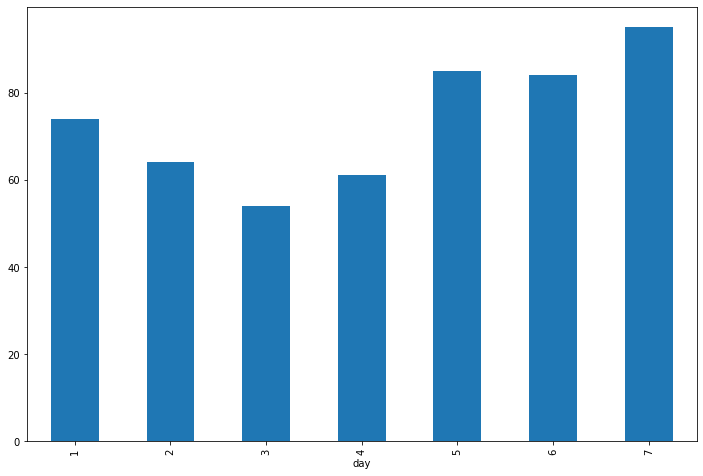

In [18]:
plt.figure(figsize=(12,8))
df.groupby("day").count()["label"].plot.bar();

<AxesSubplot:xlabel='month', ylabel='temp'>

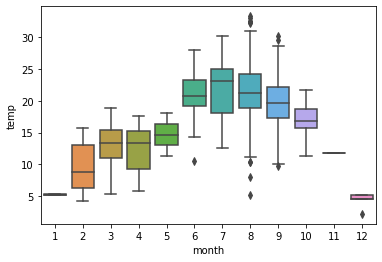

In [19]:
sns.boxplot(x=df.month,y=df.temp,data=df)

<AxesSubplot:xlabel='month', ylabel='FFMC'>

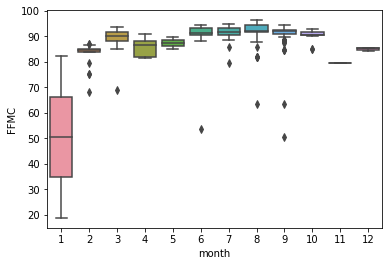

In [20]:
sns.boxplot(x=df.month,y=df.FFMC,data=df)

<AxesSubplot:xlabel='month', ylabel='DMC'>

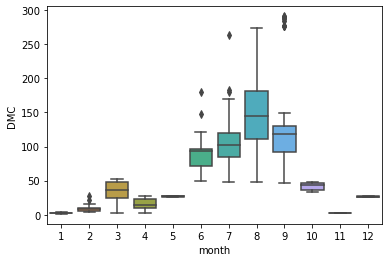

In [21]:
sns.boxplot(x=df.month,y=df.DMC,data=df)

<AxesSubplot:xlabel='month', ylabel='DC'>

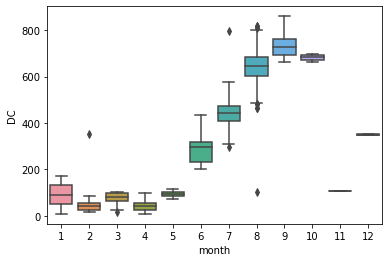

In [22]:
sns.boxplot(x=df.month,y=df.DC,data=df)

## Train Test Split & Preprocessing

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [24]:
rb_scaler = RobustScaler()
rb_scaler.fit(df.drop('label',axis=1))
scaled_features = rb_scaler.transform(df.drop('label',axis=1))
df_scale = pd.DataFrame(scaled_features,columns=df.columns[:-1])
df_scale.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0.75,1.0,-2.5,0.00,-2.000000,-1.112466,-2.063360,-0.767442,-1.520548,0.45,1.227273,0.0
1,0.75,0.0,1.0,-0.75,-0.370370,-0.987805,0.017741,-0.395349,-0.178082,-0.45,-1.409091,0.0
2,0.75,0.0,1.0,0.25,-0.370370,-0.875339,0.082187,-0.395349,-0.643836,-0.45,-1.227273,0.0
3,1.00,2.0,-2.5,0.00,0.037037,-1.016260,-2.124185,0.139535,-1.506849,2.75,0.000000,0.2
4,1.00,2.0,-2.5,0.50,-0.851852,-0.772358,-2.034757,0.279070,-1.082192,2.85,-1.000000,0.0


In [25]:
X = df_scale
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=101)

In [26]:
from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn import datasets
# fit all models
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models, predictions

/Users/Macbook/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
100%|██████████| 29/29 [00:02<00:00, 14.44it/s]


(                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
 Model                                                                           
 SGDClassifier                      0.62               0.62     0.62      0.62   
 ExtraTreesClassifier               0.59               0.59     0.59      0.59   
 BernoulliNB                        0.59               0.59     0.59      0.59   
 NearestCentroid                    0.58               0.58     0.58      0.58   
 SVC                                0.59               0.58     0.58      0.58   
 RandomForestClassifier             0.56               0.56     0.56      0.56   
 BaggingClassifier                  0.54               0.55     0.55      0.54   
 ExtraTreeClassifier                0.55               0.55     0.55      0.55   
 NuSVC                              0.56               0.55     0.55      0.56   
 PassiveAggressiveClassifier        0.58               0.55     0.55      0.55   
 DecisionTreeCla

## Logistic Regression Classification

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

In [29]:
logmodel_predicted = logmodel.predict(X_test)

In [30]:
logmodel_accuracy = metrics.accuracy_score(y_test, logmodel_predicted)
logmodel_f1 = metrics.f1_score(y_test, logmodel_predicted)

In [31]:
print("Accuracy:",metrics.accuracy_score(y_test, logmodel_predicted))
print("Precision:",metrics.precision_score(y_test, logmodel_predicted))
print("Recall:",metrics.recall_score(y_test, logmodel_predicted))
print("F1:",metrics.f1_score(y_test, logmodel_predicted))

Accuracy: 0.4935897435897436
Precision: 0.5444444444444444
Recall: 0.5632183908045977
F1: 0.5536723163841807


In [32]:
print(metrics.confusion_matrix(y_test, logmodel_predicted))
print(metrics.classification_report(y_test, logmodel_predicted))

[[28 41]
 [38 49]]
              precision    recall  f1-score   support

           0       0.42      0.41      0.41        69
           1       0.54      0.56      0.55        87

    accuracy                           0.49       156
   macro avg       0.48      0.48      0.48       156
weighted avg       0.49      0.49      0.49       156



In [33]:
df.iloc[2]

X         7.00
Y         4.00
month    10.00
day       6.00
FFMC     90.60
DMC      43.70
DC      686.90
ISI       6.70
temp     14.60
RH       33.00
wind      1.30
rain      0.00
label     0.00
Name: 2, dtype: float64

In [34]:
# Prediction
x_new=[[7, 4, 10 ,6 ,90.6, 43.7, 686.9, 6.7, 14.6, 33, 1.3, 0]]
y_predict=logmodel.predict(x_new)
print(y_predict[0])

0


## Decision Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier

In [36]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [37]:
dtree_predicted = dtree.predict(X_test)

In [38]:
dtree_accuracy = metrics.accuracy_score(y_test, dtree_predicted)
dtree_f1 = metrics.f1_score(y_test, dtree_predicted)

In [39]:
print("Accuracy:",metrics.accuracy_score(y_test, dtree_predicted))
print("Precision:",metrics.precision_score(y_test, dtree_predicted))
print("Recall:",metrics.recall_score(y_test, dtree_predicted))
print("F1:",metrics.f1_score(y_test, dtree_predicted))

Accuracy: 0.5384615384615384
Precision: 0.5842696629213483
Recall: 0.5977011494252874
F1: 0.5909090909090909


In [40]:
print(metrics.confusion_matrix(y_test, dtree_predicted))
print(metrics.classification_report(y_test, dtree_predicted))

[[32 37]
 [35 52]]
              precision    recall  f1-score   support

           0       0.48      0.46      0.47        69
           1       0.58      0.60      0.59        87

    accuracy                           0.54       156
   macro avg       0.53      0.53      0.53       156
weighted avg       0.54      0.54      0.54       156



In [41]:
# Prediction
x_new=[[7, 4, 10 ,6 ,90.6, 43.7, 686.9, 6.7, 14.6, 33, 1.3, 0]]
y_predict=dtree.predict(x_new)
print(y_predict[0])

1


## Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [43]:
rfc_predicted = rfc.predict(X_test)

In [44]:
rfc_accuracy = metrics.accuracy_score(y_test, rfc_predicted)
rfc_f1 = metrics.f1_score(y_test, rfc_predicted)

In [45]:
print("Accuracy:",metrics.accuracy_score(y_test, rfc_predicted))
print("Precision:",metrics.precision_score(y_test, rfc_predicted))
print("Recall:",metrics.recall_score(y_test, rfc_predicted))
print("F1:",metrics.f1_score(y_test, rfc_predicted))

Accuracy: 0.5769230769230769
Precision: 0.6438356164383562
Recall: 0.5402298850574713
F1: 0.5875


In [46]:
print(metrics.confusion_matrix(y_test, rfc_predicted))
print(metrics.classification_report(y_test, rfc_predicted))

[[43 26]
 [40 47]]
              precision    recall  f1-score   support

           0       0.52      0.62      0.57        69
           1       0.64      0.54      0.59        87

    accuracy                           0.58       156
   macro avg       0.58      0.58      0.58       156
weighted avg       0.59      0.58      0.58       156



In [47]:
# Prediction
x_new=[[7, 4, 10 ,6 ,90.6, 43.7, 686.9, 6.7, 14.6, 33, 1.3, 0]]
y_predict=rfc.predict(x_new)
print(y_predict[0])

1


## ExtraTreesClassifier

In [48]:
from sklearn.ensemble import ExtraTreesClassifier

In [49]:
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)

ExtraTreesClassifier()

In [50]:
etc_predicted = etc.predict(X_test)

In [51]:
etc_accuracy = metrics.accuracy_score(y_test, etc_predicted)
etc_f1 = metrics.f1_score(y_test, etc_predicted)

In [52]:
print("Accuracy:",metrics.accuracy_score(y_test, etc_predicted))
print("Precision:",metrics.precision_score(y_test, etc_predicted))
print("Recall:",metrics.recall_score(y_test, etc_predicted))
print("F1:",metrics.f1_score(y_test, etc_predicted))

Accuracy: 0.5705128205128205
Precision: 0.6219512195121951
Recall: 0.5862068965517241
F1: 0.6035502958579881


In [53]:
print(metrics.confusion_matrix(y_test, etc_predicted))
print(metrics.classification_report(y_test, etc_predicted))

[[38 31]
 [36 51]]
              precision    recall  f1-score   support

           0       0.51      0.55      0.53        69
           1       0.62      0.59      0.60        87

    accuracy                           0.57       156
   macro avg       0.57      0.57      0.57       156
weighted avg       0.57      0.57      0.57       156



In [54]:
# Prediction
x_new=[[7, 4, 10 ,6 ,90.6, 43.7, 686.9, 6.7, 14.6, 33, 1.3, 0]]
y_predict=etc.predict(x_new)
print(y_predict[0])

1


## K-Nearest

In [55]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
knn_predicted = knn.predict(X_test)

In [56]:
acc = []

for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))

Maximum accuracy:- 0.5833333333333334 at K = 30


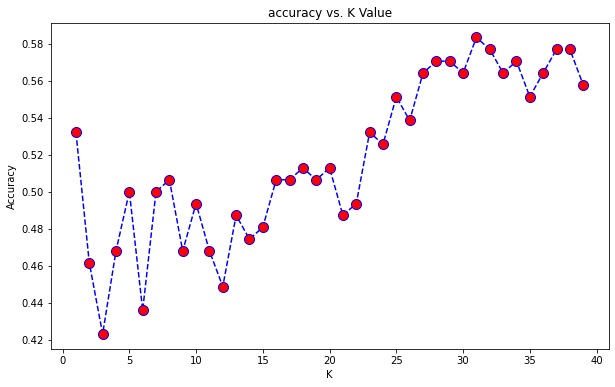

In [57]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed',
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

In [58]:
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train,y_train)
knn_predicted = knn.predict(X_test)
print('WITH K=30')
print('\n')
print(metrics.confusion_matrix(y_test,knn_predicted))
print('\n')
print(metrics.classification_report(y_test,knn_predicted))

WITH K=30


[[39 30]
 [38 49]]


              precision    recall  f1-score   support

           0       0.51      0.57      0.53        69
           1       0.62      0.56      0.59        87

    accuracy                           0.56       156
   macro avg       0.56      0.56      0.56       156
weighted avg       0.57      0.56      0.57       156



In [59]:
knn_accuracy = metrics.accuracy_score(y_test, knn_predicted)
knn_f1 = metrics.f1_score(y_test, knn_predicted)

In [60]:
print("Accuracy:",metrics.accuracy_score(y_test, knn_predicted))
print("Precision:",metrics.precision_score(y_test, knn_predicted))
print("Recall:",metrics.recall_score(y_test, knn_predicted))
print("F1:",metrics.f1_score(y_test, knn_predicted))

Accuracy: 0.5641025641025641
Precision: 0.620253164556962
Recall: 0.5632183908045977
F1: 0.5903614457831324


In [61]:
x_new=[[7, 4, 10 ,6 ,90.6, 43.7, 686.9, 6.7, 14.6, 33, 1.3, 0]]
y_predict=knn.predict(x_new)
print(y_predict[0])

1


## Gaussian Naive Bayes

In [62]:
from sklearn.naive_bayes import GaussianNB

In [63]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)

GaussianNB()

In [64]:
gnb_predicted = gnb.predict(X_test)

In [65]:
gnb_accuracy = metrics.accuracy_score(y_test, gnb_predicted)
gnb_f1 = metrics.f1_score(y_test, gnb_predicted)

In [66]:
print("Accuracy:",metrics.accuracy_score(y_test, gnb_predicted))
print("Precision:",metrics.precision_score(y_test, gnb_predicted))
print("Recall:",metrics.recall_score(y_test, gnb_predicted))
print("F1:",metrics.f1_score(y_test, gnb_predicted))

Accuracy: 0.4807692307692308
Precision: 0.5882352941176471
Recall: 0.22988505747126436
F1: 0.33057851239669417


In [67]:
print(metrics.confusion_matrix(y_test, gnb_predicted))
print(metrics.classification_report(y_test, gnb_predicted))

[[55 14]
 [67 20]]
              precision    recall  f1-score   support

           0       0.45      0.80      0.58        69
           1       0.59      0.23      0.33        87

    accuracy                           0.48       156
   macro avg       0.52      0.51      0.45       156
weighted avg       0.53      0.48      0.44       156



In [68]:
x_new=[[7, 4, 10 ,6 ,90.6, 43.7, 686.9, 6.7, 14.6, 33, 1.3, 0]]
y_predict=gnb.predict(x_new)
print(y_predict[0])

0


Text(0.5, 1.0, 'Accuracy Score of Different Models')

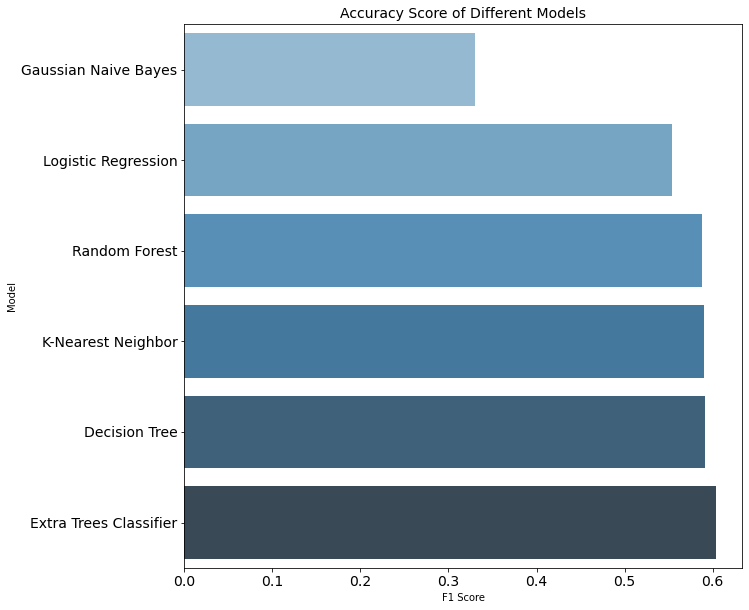

In [69]:
compare = pd.DataFrame({"Model": ["Logistic Regression","Decision Tree","Random Forest","Extra Trees Classifier","K-Nearest Neighbor","Gaussian Naive Bayes"],
                        "F1 Score": [logmodel_f1,dtree_f1,rfc_f1,etc_f1,knn_f1,gnb_f1]})

compare = compare.sort_values(by="F1 Score", ascending=True)

plt.figure(figsize=(10,10))
ax = sns.barplot(x="F1 Score", y="Model", data=compare, palette="Blues_d")

plt.yticks(size = 14)
plt.xticks(size = 14)
plt.title("Accuracy Score of Different Models", size=14)

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [71]:
models = []
models.append(('LR', LogisticRegression(max_iter=5000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('MLP', MLPClassifier()))
models.append(('GradientBoost',GradientBoostingClassifier()))
models.append(('AdaBoost',AdaBoostClassifier()))
models.append(('Bagging',BaggingClassifier()))
models.append(('RandomForest',RandomForestClassifier()))
models.append(('ExtraTrees',ExtraTreesClassifier()))

In [72]:
results = []
names = []
scoring = 'f1'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X, y,   cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.432481 (0.226991)
KNN: 0.416296 (0.224728)
CART: 0.449684 (0.226411)
NB: 0.241389 (0.263735)
SVM: 0.463112 (0.235956)
MLP: 0.413190 (0.233029)
GradientBoost: 0.437303 (0.236952)
AdaBoost: 0.423435 (0.237227)
Bagging: 0.405349 (0.221366)
RandomForest: 0.419544 (0.222726)
ExtraTrees: 0.435763 (0.232215)


https://www.kaggle.com/psvishnu/forestfire-impact-prediction-stats-and-ml